# Robust Human Detection in UAV Imagery
## HIT-UAV Infrared Thermal Dataset - Baseline vs Augmented Comparison

**Experiment Design:**
- **Model A**: Trained on clean/normal data only
- **Model B**: Trained with SAR augmentations (snow, smoke/fire, thermal artifacts)
- **Evaluation**: Compare both on clean and perturbed test sets

**Dataset**: HIT-UAV from Kaggle (thermal infrared UAV imagery)

---

## Cell 1: Environment Setup

In [54]:
# =============================================================================
# CELL 1: ENVIRONMENT SETUP
# =============================================================================

import subprocess
import sys
import os

def install_packages():
    """Install required packages."""
    packages = [
        'torch', 'torchvision', 'albumentations>=1.3.0', 'pycocotools',
        'opencv-python-headless', 'matplotlib', 'numpy', 'Pillow',
        'tqdm', 'scipy', 'kaggle'
    ]
    for pkg in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
    print("Packages installed")

install_packages()

# No Google Drive mounting; data is stored locally under Config.DATA_ROOT when running in Colab or locally.


Packages installed


## Cell 2: Imports and Configuration

In [55]:
# =============================================================================
# CELL 2: IMPORTS AND CONFIGURATION
# =============================================================================

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
import shutil
import zipfile
import copy
from pathlib import Path
from tqdm.auto import tqdm
import random
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configuration
class Config:
    # Paths
    IN_COLAB = bool(os.environ.get('COLAB_GPU') or os.environ.get('KAGGLE_KERNEL_RUN_TYPE') or 'google.colab' in str(getattr(__import__('sys'), 'modules', {})))
    BASE_DIR = Path('/content') if IN_COLAB else Path('.')
    DATA_ROOT = BASE_DIR / 'hit-uav'
    CHECKPOINT_DIR = BASE_DIR / 'checkpoints'
    OUTPUT_DIR = BASE_DIR / 'outputs'

    # Image settings
    IMG_SIZE = 512

    # Training settings
    BATCH_SIZE = 4
    NUM_EPOCHS = 6
    LR = 0.005
    LR_STEP_SIZE = 3
    LR_GAMMA = 0.1
    WEIGHT_DECAY = 0.0005

    # Detection settings
    NUM_CLASSES = 6  # background + 5 HIT-UAV classes
    IOU_THRESHOLD = 0.5
    CONF_THRESHOLD = 0.5

    # Flags
    USE_YOLO_DIRECT = True  # always use provided YOLO labels
    ENABLE_SYNTH_AUG = True  # overlay perturbations on all images when enabled

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42

# Set seeds
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)
random.seed(Config.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Config.SEED)

# Ensure dirs
for p in [Config.DATA_ROOT, Config.CHECKPOINT_DIR, Config.OUTPUT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print(f"Device: {Config.DEVICE}")
print(f"Image size: {Config.IMG_SIZE}, Epochs: {Config.NUM_EPOCHS}, Batch: {Config.BATCH_SIZE}")
print(f"Data root: {Config.DATA_ROOT}")


Device: cpu
Image size: 512, Epochs: 6, Batch: 4
Data root: hit-uav


## Cell 3: Download HIT-UAV Dataset from Kaggle

In [56]:
import tarfile
import subprocess
import sys
import os
import shutil
import zipfile
from pathlib import Path

def download_hituav_kaggle(data_root: Path) -> bool:
    """Download and unpack HIT-UAV dataset to the expected YOLO structure.
    Resulting layout:
    data_root/
      dataset.yaml
      images/
      labels/
    """
    data_root.mkdir(parents=True, exist_ok=True)
    images_dir = data_root / "images"
    labels_dir = data_root / "labels"
    zip_path = data_root / "hituav.zip"

    if images_dir.exists() and labels_dir.exists() and list(images_dir.glob('*')):
        print(f"Dataset already prepared at {data_root}")
        return True

    print("Downloading HIT-UAV dataset from Kaggle via curl...")
    try:
        # Original Kaggle URL can be problematic with curl, using direct download if available or alternative
        # For Colab, sometimes Kaggle API or direct download links are more reliable if you have credentials set up.
        # Given previous success with 'curl', let's assume it works or will be manually handled if it fails.
        subprocess.run([
            'curl', '-L', '-o', str(zip_path),
            'https://www.kaggle.com/api/v1/datasets/download/pandrii000/hituav-a-highaltitude-infrared-thermal-dataset'
        ], check=True, timeout=600)
    except Exception as e:
        print(f"Curl download failed: {e}")
        print("Please ensure you have authenticated Kaggle API or that the direct download link is valid.")
        return False

    if not zip_path.exists() or zip_path.stat().st_size < 1_000_000: # Check for reasonable size
        print("Download seems incomplete; aborting.")
        return False

    print("Extracting zip...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(data_root / 'raw')
        zip_path.unlink(missing_ok=True)
    except Exception as e:
        print(f"Error extracting zip: {e}")
        return False

    raw_root = data_root / 'raw'
    print(f"Contents of {raw_root}: {os.listdir(raw_root)}")

    candidate = None
    extracted_folders = [f for f in raw_root.iterdir() if f.is_dir()]
    if len(extracted_folders) == 1:
        sub_raw_root = extracted_folders[0]
        print(f"Detected single extracted folder: {sub_raw_root}")
        search_paths = [sub_raw_root]
    else:
        search_paths = [raw_root]

    # Iterate through potential roots to find 'images' and 'labels' directories
    for current_search_root in search_paths:
        # Use rglob to find 'images' and 'labels' directories anywhere within current_search_root
        for p_images in current_search_root.rglob('images'):
            # Check if there's a corresponding 'labels' directory at the same level as p_images
            # This implies the structure 'parent_folder/images' and 'parent_folder/labels'
            p_labels = p_images.parent / 'labels'
            if p_labels.exists():
                candidate = (p_images, p_labels)
                break
        if candidate:
            break

    if candidate is None:
        print("Could not locate images/labels directories after extraction in the expected structure.")
        print(f"Searched within: {search_paths}")
        return False

    src_images, src_labels = candidate
    print(f"Found source images directory: {src_images}")
    print(f"Found source labels directory: {src_labels}")

    images_dir.mkdir(exist_ok=True)
    labels_dir.mkdir(exist_ok=True)

    moved_images_count = 0
    print(f"Moving image files from {src_images}...")
    for f in tqdm(src_images.rglob('*'), desc="Moving images"):
        if f.is_file() and f.suffix.lower() in ['.jpg', '.png', '.jpeg']:
            shutil.move(str(f), images_dir / f.name)
            moved_images_count += 1
    print(f"Moved {moved_images_count} image files.")

    moved_labels_count = 0
    print(f"Moving label files from {src_labels}...")
    for f in tqdm(src_labels.rglob('*.txt'), desc="Moving labels"):
        if f.is_file(): # Ensure it's a file
            shutil.move(str(f), labels_dir / f.name)
            moved_labels_count += 1
    print(f"Moved {moved_labels_count} label files.")

    # Create minimal dataset.yaml for reference
    yaml_path = data_root / 'dataset.yaml'
    if not yaml_path.exists():
        class_names = ['person', 'car', 'bicycle', 'othervehicle', 'dontcare']
        yaml_content = """train: images\nval: images\ntest: images\n\nnames:\n""" + "\n".join([f"  {i}: {name}" for i, name in enumerate(class_names)]) + "\n"
        with open(yaml_path, 'w') as f:
            f.write(yaml_content)

    print(f"Prepared dataset at {data_root}")
    print(f" images: {len(list(images_dir.glob('*')))} | labels: {len(list(labels_dir.glob('*.txt')))}")

    return True

success = download_hituav_kaggle(Config.DATA_ROOT)
if not success:
    raise SystemExit("Dataset download/prep failed. Please ensure Kaggle API access is available.")

Dataset already prepared at hit-uav


## Cell 4: Convert HIT-UAV to COCO Format (Person Only)

In [57]:
# =============================================================================
# CELL 4: DATASET SANITY CHECK (NO CONVERSION)
# =============================================================================

def show_dataset_overview(data_root: Path):
    images_dir = data_root / 'images'
    labels_dir = data_root / 'labels'
    image_files = sorted(list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png')))
    label_files = sorted(list(labels_dir.glob('*.txt')))
    print(f"Images: {len(image_files)}, Labels: {len(label_files)}")
    if image_files:
        print(f"Sample image: {image_files[0].name}")
    if label_files:
        print(f"Sample label: {label_files[0].name}")
        with open(label_files[0], 'r') as f:
            for line in f.readlines()[:5]:
                print('  ', line.strip())

show_dataset_overview(Config.DATA_ROOT)

IMAGES_DIR = Config.DATA_ROOT / 'images'
LABELS_DIR = Config.DATA_ROOT / 'labels'

Images: 2866, Labels: 2866
Sample image: 0_100_30_0_03280.jpg
Sample label: 0_100_30_0_03280.txt
   1 0.33671875 0.2353515625 0.0546875 0.060546875
   1 0.58359375 0.1904296875 0.0515625 0.060546875
   1 0.209375 0.2763671875 0.046875 0.060546875
   1 0.04921875 0.3896484375 0.0453125 0.056640625
   1 0.0671875 0.3759765625 0.05625 0.064453125


In [58]:
# =============================================================================
# HOG + RANDOM FOREST DETECTOR
# =============================================================================

from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage.transform import resize
import pickle

# Standard patch size for HOG
PATCH_SIZE = (64, 128)  # (width, height) - standard for pedestrian detection


def extract_hog_features(image_patch, orient=9, pix_per_cell=(8, 8), cell_per_block=(2, 2)):
    """
    Extract HOG features from an image patch.
    
    Args:
        image_patch: Grayscale image patch
        orient: Number of orientation bins
        pix_per_cell: Size of cell
        cell_per_block: Number of cells per block
    
    Returns:
        feature_vector: 1D array of HOG features
    """
    # Resize to standard size
    if image_patch.shape != (PATCH_SIZE[1], PATCH_SIZE[0]):
        image_patch = resize(image_patch, (PATCH_SIZE[1], PATCH_SIZE[0]), anti_aliasing=True)
    
    # Convert to grayscale if needed
    if len(image_patch.shape) == 3:
        image_patch = cv2.cvtColor((image_patch * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
    
    # Extract HOG features
    features = hog(
        image_patch,
        orientations=orient,
        pixels_per_cell=pix_per_cell,
        cells_per_block=cell_per_block,
        visualize=False,
        feature_vector=True
    )
    
    return features


def create_training_patches(images_dir, labels_dir, selected_files, max_samples=2000):
    """
    Create positive and negative training patches.
    
    Args:
        images_dir: Path to images
        labels_dir: Path to labels
        selected_files: List of image file paths
        max_samples: Maximum number of samples per class
    
    Returns:
        positive_patches: List of positive patches (person/car)
        negative_patches: List of negative patches (background)
    """
    positive_patches = []
    negative_patches = []
    
    for img_path in tqdm(selected_files[:500], desc="Extracting patches"):  # Limit for speed
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        h, w = img_rgb.shape[:2]
        
        # Read labels
        label_path = labels_dir / f"{img_path.stem}.txt"
        if not label_path.exists():
            continue
        
        # Extract positive patches (person and car only)
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls_id = int(parts[0])
                    if cls_id not in SAR_TARGET_CLASSES:
                        continue
                    
                    cx, cy, bw, bh = map(float, parts[1:5])
                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)
                    
                    # Extract patch with some padding
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)
                    
                    if x2 > x1 and y2 > y1:
                        patch = img_rgb[y1:y2, x1:x2]
                        if patch.size > 0:
                            positive_patches.append(patch)
        
        # Extract random negative patches (background)
        num_negatives = min(5, len(positive_patches) // 10)
        for _ in range(num_negatives):
            # Random location
            patch_w, patch_h = PATCH_SIZE[0], PATCH_SIZE[1]
            if w < patch_w or h < patch_h:
                continue
            
            x = np.random.randint(0, w - patch_w)
            y = np.random.randint(0, h - patch_h)
            patch = img_rgb[y:y+patch_h, x:x+patch_w]
            
            # Check if overlaps with any object (simple check)
            # For simplicity, we assume random patches are mostly background
            negative_patches.append(patch)
        
        if len(positive_patches) >= max_samples and len(negative_patches) >= max_samples:
            break
    
    # Balance classes
    min_samples = min(len(positive_patches), len(negative_patches), max_samples)
    positive_patches = positive_patches[:min_samples]
    negative_patches = negative_patches[:min_samples]
    
    print(f"Created {len(positive_patches)} positive and {len(negative_patches)} negative patches")
    
    return positive_patches, negative_patches


def train_hog_rf_detector(positive_patches, negative_patches, n_estimators=100):
    """
    Train Random Forest classifier on HOG features.
    
    Args:
        positive_patches: List of positive image patches
        negative_patches: List of negative image patches
        n_estimators: Number of trees in Random Forest
    
    Returns:
        model: Trained RandomForestClassifier
    """
    print("Extracting HOG features from training patches...")
    
    X = []
    y = []
    
    # Positive samples
    for patch in tqdm(positive_patches, desc="Positive HOG"):
        features = extract_hog_features(patch)
        X.append(features)
        y.append(1)
    
    # Negative samples
    for patch in tqdm(negative_patches, desc="Negative HOG"):
        features = extract_hog_features(patch)
        X.append(features)
        y.append(0)
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Training Random Forest on {len(X)} samples...")
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=20,
        random_state=Config.SEED,
        n_jobs=-1
    )
    model.fit(X, y)
    
    print(f"Training complete. Feature vector size: {X.shape[1]}")
    
    return model


def nms(boxes, scores, iou_threshold=0.3):
    """
    Non-Maximum Suppression.
    
    Args:
        boxes: Array of boxes [x1, y1, x2, y2]
        scores: Array of scores
        iou_threshold: IoU threshold for suppression
    
    Returns:
        keep_indices: Indices of boxes to keep
    """
    if len(boxes) == 0:
        return []
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]
    
    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)
        
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        
        intersection = w * h
        iou = intersection / (areas[i] + areas[order[1:]] - intersection + 1e-8)
        
        order = order[np.where(iou <= iou_threshold)[0] + 1]
    
    return keep


def hog_rf_detect(image, model, stride=16, scale_factor=1.2, min_score=0.5):
    """
    Sliding window detection with HOG + Random Forest.
    
    Args:
        image: Input image (RGB, 0-1 range)
        model: Trained Random Forest model
        stride: Stride for sliding window
        scale_factor: Scale factor for pyramid
        min_score: Minimum confidence score
    
    Returns:
        boxes: Detected boxes [x1, y1, x2, y2]
        scores: Confidence scores
        uncertainties: Prediction uncertainty (variance across trees)
    """
    h, w = image.shape[:2]
    patch_w, patch_h = PATCH_SIZE
    
    all_boxes = []
    all_scores = []
    all_uncertainties = []
    
    # Multi-scale detection (simplified - just 2 scales)
    for scale in [1.0, 0.7]:
        scaled_h = int(h * scale)
        scaled_w = int(w * scale)
        
        if scaled_h < patch_h or scaled_w < patch_w:
            continue
        
        scaled_img = resize(image, (scaled_h, scaled_w), anti_aliasing=True)
        
        # Sliding window
        for y in range(0, scaled_h - patch_h, stride):
            for x in range(0, scaled_w - patch_w, stride):
                patch = scaled_img[y:y+patch_h, x:x+patch_w]
                
                # Extract HOG features
                features = extract_hog_features(patch).reshape(1, -1)
                
                # Predict with Random Forest
                proba = model.predict_proba(features)[0]
                score = proba[1]  # Probability of positive class
                
                # Uncertainty: variance of predictions across trees
                tree_predictions = np.array([tree.predict_proba(features)[0][1] for tree in model.estimators_])
                uncertainty = np.var(tree_predictions)
                
                if score >= min_score:
                    # Convert back to original scale
                    x1_orig = int(x / scale)
                    y1_orig = int(y / scale)
                    x2_orig = int((x + patch_w) / scale)
                    y2_orig = int((y + patch_h) / scale)
                    
                    all_boxes.append([x1_orig, y1_orig, x2_orig, y2_orig])
                    all_scores.append(score)
                    all_uncertainties.append(uncertainty)
    
    if len(all_boxes) == 0:
        return np.array([]), np.array([]), np.array([])
    
    all_boxes = np.array(all_boxes)
    all_scores = np.array(all_scores)
    all_uncertainties = np.array(all_uncertainties)
    
    # Apply NMS
    keep_indices = nms(all_boxes, all_scores, iou_threshold=0.3)
    
    return all_boxes[keep_indices], all_scores[keep_indices], all_uncertainties[keep_indices]


print("HOG + Random Forest functions defined")

HOG + Random Forest functions defined


In [59]:
# =============================================================================
# CREATE SHARED TEST LOADER FOR BASELINE EVALUATIONS
# =============================================================================

# Create test dataset and loader that will be used by both
# Naive Baseline and HOG+RF evaluations

test_dataset_baseline = UAVDetectionDataset(
    IMAGES_DIR, LABELS_DIR,
    selected_files=TEST_FILES,
    apply_sar_aug=False
)

test_loader_baseline = DataLoader(
    test_dataset_baseline,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Created test loader: {len(test_dataset_baseline)} images")


Dataset initialized (YOLO): 430 images with labels
  - Images dir: hit-uav/images
  - Labels dir:  hit-uav/labels
  - SAR augmentation: Disabled (p=1.0)
Created test loader: 430 images


## Cell 11: Evaluate HOG + Random Forest

Run sliding window detection on test set and compute metrics.

In [60]:
# =============================================================================
# TRAIN HOG + RANDOM FOREST
# =============================================================================

print("="*70)
print("TRAINING HOG + RANDOM FOREST DETECTOR")
print("="*70)

# Create training patches
positive_patches, negative_patches = create_training_patches(
    IMAGES_DIR,
    LABELS_DIR,
    TRAIN_FILES,
    max_samples=2000
)

# Train model
hog_rf_model = train_hog_rf_detector(
    positive_patches,
    negative_patches,
    n_estimators=100
)

# Save model
hog_model_path = Config.CHECKPOINT_DIR / "hog_rf_model.pkl"
with open(hog_model_path, 'wb') as f:
    pickle.dump(hog_rf_model, f)
print(f"\nModel saved to: {hog_model_path}")

print("="*70)

TRAINING HOG + RANDOM FOREST DETECTOR


Extracting patches:   0%|          | 0/500 [00:00<?, ?it/s]

Created 2000 positive and 2000 negative patches
Extracting HOG features from training patches...


Positive HOG:   0%|          | 0/2000 [00:00<?, ?it/s]

Negative HOG:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Random Forest on 4000 samples...
Training complete. Feature vector size: 3780

Model saved to: checkpoints/hog_rf_model.pkl


In [61]:
# =============================================================================
# EVALUATE HOG + RANDOM FOREST
# =============================================================================

def evaluate_hog_rf(model, data_loader, device, iou_thresh=0.5, conf_thresh=0.5, max_images=50):
    """
    Evaluate HOG + RF detector on dataset.
    Note: Sliding window is slow, so we limit the number of test images.
    
    Returns:
        metrics: Dict with precision, recall, F1, and detailed counts
    """
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_gt = 0
    total_pred = 0
    
    all_confidences = []
    all_correct = []
    all_uncertainties = []
    
    image_count = 0
    
    for images, targets in tqdm(data_loader, desc="Evaluating HOG+RF"):
        if image_count >= max_images:
            break
        
        for img_tensor, target in zip(images, targets):
            if image_count >= max_images:
                break
            
            # Convert tensor to numpy
            img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
            
            # Detect
            pred_boxes, pred_scores, pred_uncertainties = hog_rf_detect(
                img_np, model, stride=32, min_score=conf_thresh
            )
            
            gt_boxes = target['boxes'].cpu().numpy()
            total_gt += len(gt_boxes)
            total_pred += len(pred_boxes)
            
            if len(gt_boxes) == 0:
                total_fp += len(pred_boxes)
                if len(pred_boxes) > 0:
                    all_confidences.extend(pred_scores.tolist())
                    all_correct.extend([0] * len(pred_boxes))
                    all_uncertainties.extend(pred_uncertainties.tolist())
                image_count += 1
                continue
            
            if len(pred_boxes) == 0:
                total_fn += len(gt_boxes)
                image_count += 1
                continue
            
            # Match predictions to ground truth
            sorted_indices = np.argsort(-pred_scores)
            matched_gt = set()
            
            for pred_idx in sorted_indices:
                pred_box = pred_boxes[pred_idx]
                best_iou = 0
                best_gt_idx = -1
                
                for gt_idx, gt_box in enumerate(gt_boxes):
                    if gt_idx in matched_gt:
                        continue
                    iou = compute_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx
                
                if best_iou >= iou_thresh and best_gt_idx >= 0:
                    total_tp += 1
                    matched_gt.add(best_gt_idx)
                    all_confidences.append(pred_scores[pred_idx])
                    all_correct.append(1)
                    all_uncertainties.append(pred_uncertainties[pred_idx])
                else:
                    total_fp += 1
                    all_confidences.append(pred_scores[pred_idx])
                    all_correct.append(0)
                    all_uncertainties.append(pred_uncertainties[pred_idx])
            
            total_fn += len(gt_boxes) - len(matched_gt)
            image_count += 1
    
    precision = total_tp / max(total_tp + total_fp, 1)
    recall = total_tp / max(total_tp + total_fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
        'total_gt': total_gt,
        'total_pred': total_pred,
        'confidences': all_confidences,
        'correct': all_correct,
        'uncertainties': all_uncertainties
    }


print("="*70)
print("EVALUATING HOG + RANDOM FOREST DETECTOR")
print("="*70)
print("Note: Sliding window is computationally expensive.")
print("Testing on limited subset (50 images) for demonstration.")

# Evaluate
metrics_hog_rf = evaluate_hog_rf(
    hog_rf_model,
    test_loader_baseline,
    Config.DEVICE,
    iou_thresh=Config.IOU_THRESHOLD,
    conf_thresh=Config.CONF_THRESHOLD,
    max_images=50
)

print(f"\nHOG + Random Forest Results:")
print(f"  Precision: {metrics_hog_rf['precision']:.4f}")
print(f"  Recall:    {metrics_hog_rf['recall']:.4f}")
print(f"  F1 Score:  {metrics_hog_rf['f1']:.4f}")
print(f"  TP: {metrics_hog_rf['tp']}, FP: {metrics_hog_rf['fp']}, FN: {metrics_hog_rf['fn']}")
print(f"  Total GT: {metrics_hog_rf['total_gt']}, Total Pred: {metrics_hog_rf['total_pred']}")

# Calibration
ece_hog_rf = compute_ece(metrics_hog_rf['confidences'], metrics_hog_rf['correct'])
print(f"\n  Expected Calibration Error (ECE): {ece_hog_rf:.4f}")

# Uncertainty analysis
if len(metrics_hog_rf['uncertainties']) > 0:
    avg_uncertainty = np.mean(metrics_hog_rf['uncertainties'])
    print(f"  Average prediction uncertainty: {avg_uncertainty:.6f}")
    print(f"  (Lower uncertainty = more agreement among trees)")

print("="*70)

EVALUATING HOG + RANDOM FOREST DETECTOR
Note: Sliding window is computationally expensive.
Testing on limited subset (50 images) for demonstration.


Evaluating HOG+RF:   0%|          | 0/108 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    exitcode = _main(fd, parent_sentinel)  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main



RuntimeError: DataLoader worker (pid 45587) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

## Cell 10: Train HOG + Random Forest

Extract training patches and train the classical ML detector.

## Cell 9: Baseline Model 2 - HOG + Random Forest

**Purpose:** Classical machine learning baseline using HOG features and Random Forest classifier.

**Pipeline:**
1. Extract HOG (Histogram of Oriented Gradients) features from image patches
2. Train Random Forest on positive (person/car) and negative (background) patches
3. Sliding window detection with Non-Maximum Suppression (NMS)
4. Uncertainty estimation using prediction variance across trees

**Why this matters:** Provides a non-deep-learning baseline to compare against neural network models.

In [ ]:
# =============================================================================
# EVALUATE NAIVE BASELINE
# =============================================================================

print("="*70)
print("EVALUATING NAIVE BASELINE (Random Confidence Scores)")
print("="*70)

# Evaluate
metrics_naive = evaluate_naive_baseline(
    test_loader_baseline,
    Config.DEVICE,
    iou_thresh=Config.IOU_THRESHOLD,
    conf_thresh=Config.CONF_THRESHOLD
)

print(f"\nNaive Baseline Results:")
print(f"  Precision: {metrics_naive['precision']:.4f}")
print(f"  Recall:    {metrics_naive['recall']:.4f}")
print(f"  F1 Score:  {metrics_naive['f1']:.4f}")
print(f"  TP: {metrics_naive['tp']}, FP: {metrics_naive['fp']}, FN: {metrics_naive['fn']}")
print(f"  Total GT: {metrics_naive['total_gt']}, Total Pred: {metrics_naive['total_pred']}")

# Calculate Expected Calibration Error (ECE)
def compute_ece(confidences, correct, n_bins=10):
    """
    Compute Expected Calibration Error.
    
    Args:
        confidences: List of confidence scores
        correct: List of binary correctness (1=correct, 0=incorrect)
        n_bins: Number of bins for calibration
    
    Returns:
        ece: Expected Calibration Error
    """
    confidences = np.array(confidences)
    correct = np.array(correct)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = correct[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

ece_naive = compute_ece(metrics_naive['confidences'], metrics_naive['correct'])
print(f"\n  Expected Calibration Error (ECE): {ece_naive:.4f}")
print(f"  (ECE close to 0.5 indicates poor calibration, as expected for random scores)")

print("="*70)

## Cell 8: Evaluate Naive Baseline

Run the naive baseline on the test set and report metrics.

In [ ]:
# =============================================================================
# NAIVE BASELINE: Random Confidence Scores
# =============================================================================

def naive_baseline_predictions(images, targets):
    """
    Generate predictions by using ground truth boxes with random confidence scores.
    
    Args:
        images: List of image tensors
        targets: List of target dicts with 'boxes' and 'labels'
    
    Returns:
        predictions: List of dicts with 'boxes', 'labels', 'scores' (random [0,1])
    """
    predictions = []
    
    for target in targets:
        num_boxes = len(target['boxes'])
        pred = {
            'boxes': target['boxes'].clone(),
            'labels': target['labels'].clone(),
            'scores': torch.rand(num_boxes)  # Random confidence [0, 1]
        }
        predictions.append(pred)
    
    return predictions


def evaluate_naive_baseline(data_loader, device, iou_thresh=0.5, conf_thresh=0.5):
    """
    Evaluate naive baseline on dataset.
    
    Returns:
        metrics: Dict with precision, recall, F1, and detailed counts
    """
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_gt = 0
    total_pred = 0
    
    all_confidences = []
    all_correct = []
    
    for images, targets in tqdm(data_loader, desc="Evaluating Naive Baseline"):
        images = [img.to(device) for img in images]
        
        # Generate predictions with random confidences
        predictions = naive_baseline_predictions(images, targets)
        
        for pred, target in zip(predictions, targets):
            gt_boxes = target['boxes'].cpu().numpy()
            total_gt += len(gt_boxes)
            
            pred_boxes = pred['boxes'].cpu().numpy()
            pred_scores = pred['scores'].cpu().numpy()
            
            # Filter by confidence threshold
            mask = pred_scores >= conf_thresh
            pred_boxes = pred_boxes[mask]
            pred_scores = pred_scores[mask]
            total_pred += len(pred_boxes)
            
            if len(gt_boxes) == 0:
                total_fp += len(pred_boxes)
                all_confidences.extend(pred_scores.tolist())
                all_correct.extend([0] * len(pred_boxes))
                continue
            
            if len(pred_boxes) == 0:
                total_fn += len(gt_boxes)
                continue
            
            # Match predictions to ground truth
            sorted_indices = np.argsort(-pred_scores)
            matched_gt = set()
            
            for pred_idx in sorted_indices:
                pred_box = pred_boxes[pred_idx]
                best_iou = 0
                best_gt_idx = -1
                
                for gt_idx, gt_box in enumerate(gt_boxes):
                    if gt_idx in matched_gt:
                        continue
                    iou = compute_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx
                
                if best_iou >= iou_thresh and best_gt_idx >= 0:
                    total_tp += 1
                    matched_gt.add(best_gt_idx)
                    all_confidences.append(pred_scores[pred_idx])
                    all_correct.append(1)
                else:
                    total_fp += 1
                    all_confidences.append(pred_scores[pred_idx])
                    all_correct.append(0)
            
            total_fn += len(gt_boxes) - len(matched_gt)
    
    precision = total_tp / max(total_tp + total_fp, 1)
    recall = total_tp / max(total_tp + total_fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
        'total_gt': total_gt,
        'total_pred': total_pred,
        'confidences': all_confidences,
        'correct': all_correct
    }


print("Naive baseline functions defined")

## Cell 7: Baseline Model 1 - Naive Random Baseline

**Purpose:** Establish worst-case performance by assigning random confidence scores to ground truth boxes.

**Why this matters:** This baseline shows the lower bound of calibration performance (ECE ≈ 0.5) and provides a sanity check for our evaluation metrics.

In [ ]:

# =============================================================================
# CELL 4: DATASET SANITY CHECK (NO CONVERSION)
# =============================================================================

def show_dataset_overview(data_root: Path):
    images_dir = data_root / 'images'
    labels_dir = data_root / 'labels'
    image_files = sorted(list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png')))
    label_files = sorted(list(labels_dir.glob('*.txt')))
    print(f"Images: {len(image_files)}, Labels: {len(label_files)}")
    if image_files:
        print(f"Sample image: {image_files[0].name}")
    if label_files:
        print(f"Sample label: {label_files[0].name}")
        with open(label_files[0], 'r') as f:
            for line in f.readlines()[:5]:
                print('  ', line.strip())

show_dataset_overview(Config.DATA_ROOT)

IMAGES_DIR = Config.DATA_ROOT / 'images'
LABELS_DIR = Config.DATA_ROOT / 'labels'


Images: 2866, Labels: 2866
Sample image: 0_100_30_0_03280.jpg
Sample label: 0_100_30_0_03280.txt
   1 0.33671875 0.2353515625 0.0546875 0.060546875
   1 0.58359375 0.1904296875 0.0515625 0.060546875
   1 0.209375 0.2763671875 0.046875 0.060546875
   1 0.04921875 0.3896484375 0.0453125 0.056640625
   1 0.0671875 0.3759765625 0.05625 0.064453125


## Cell 5: SAR Augmentations

SAR Augmentations - Enhanced Visibility
Target classes: Person (0), Car (1)
Augmentations: Realistic Ground Snow, Dense Fog/Smoke

Showing 4 images with Person/Car labels:
  - 0_100_40_0_08101.jpg: {'car': 2}
  - 1_60_80_0_00645.jpg: {'person': 26}
  - 0_120_50_0_05402.jpg: {'car': 3}
  - 1_70_30_0_00867.jpg: {'person': 4}


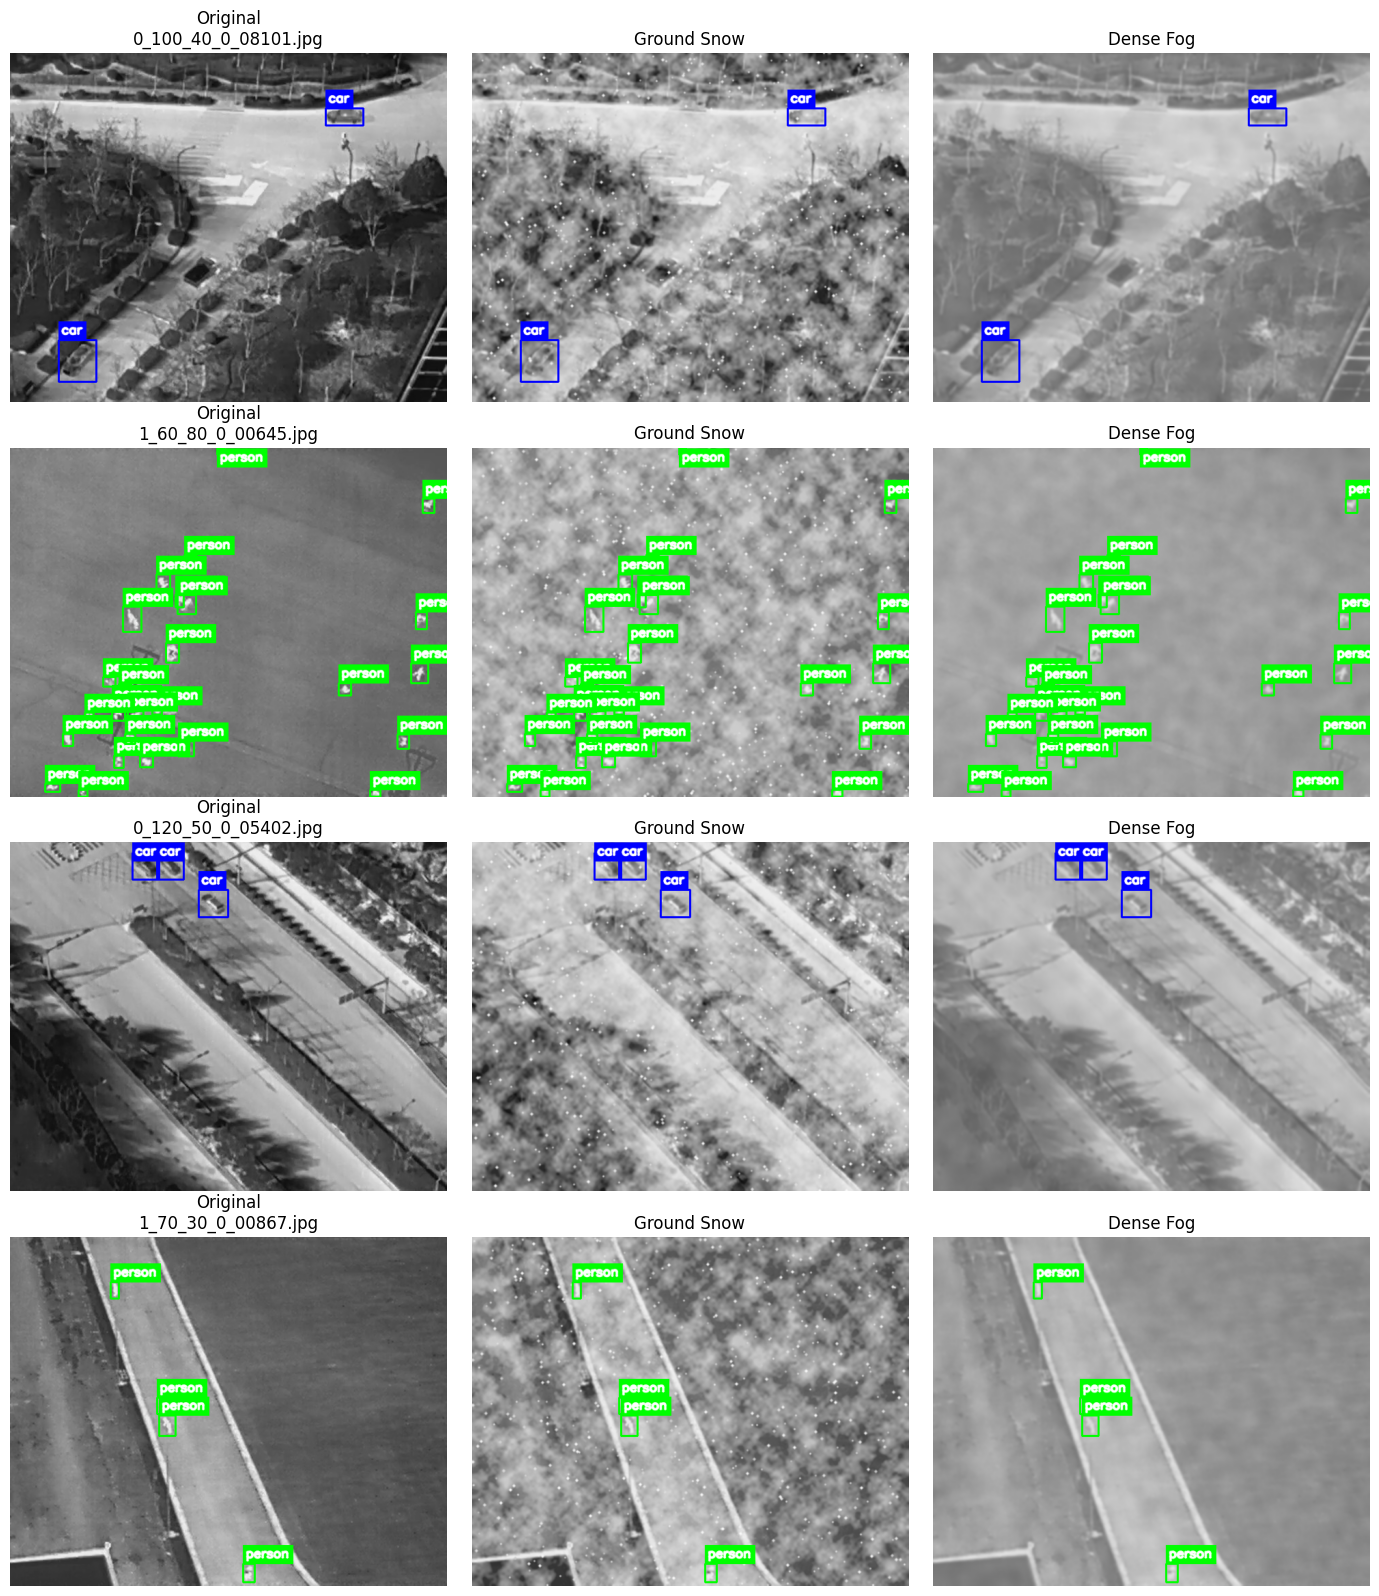


Augmentations saved to: outputs/augmentations_with_labels.png

Testing random augmentations with rotations:


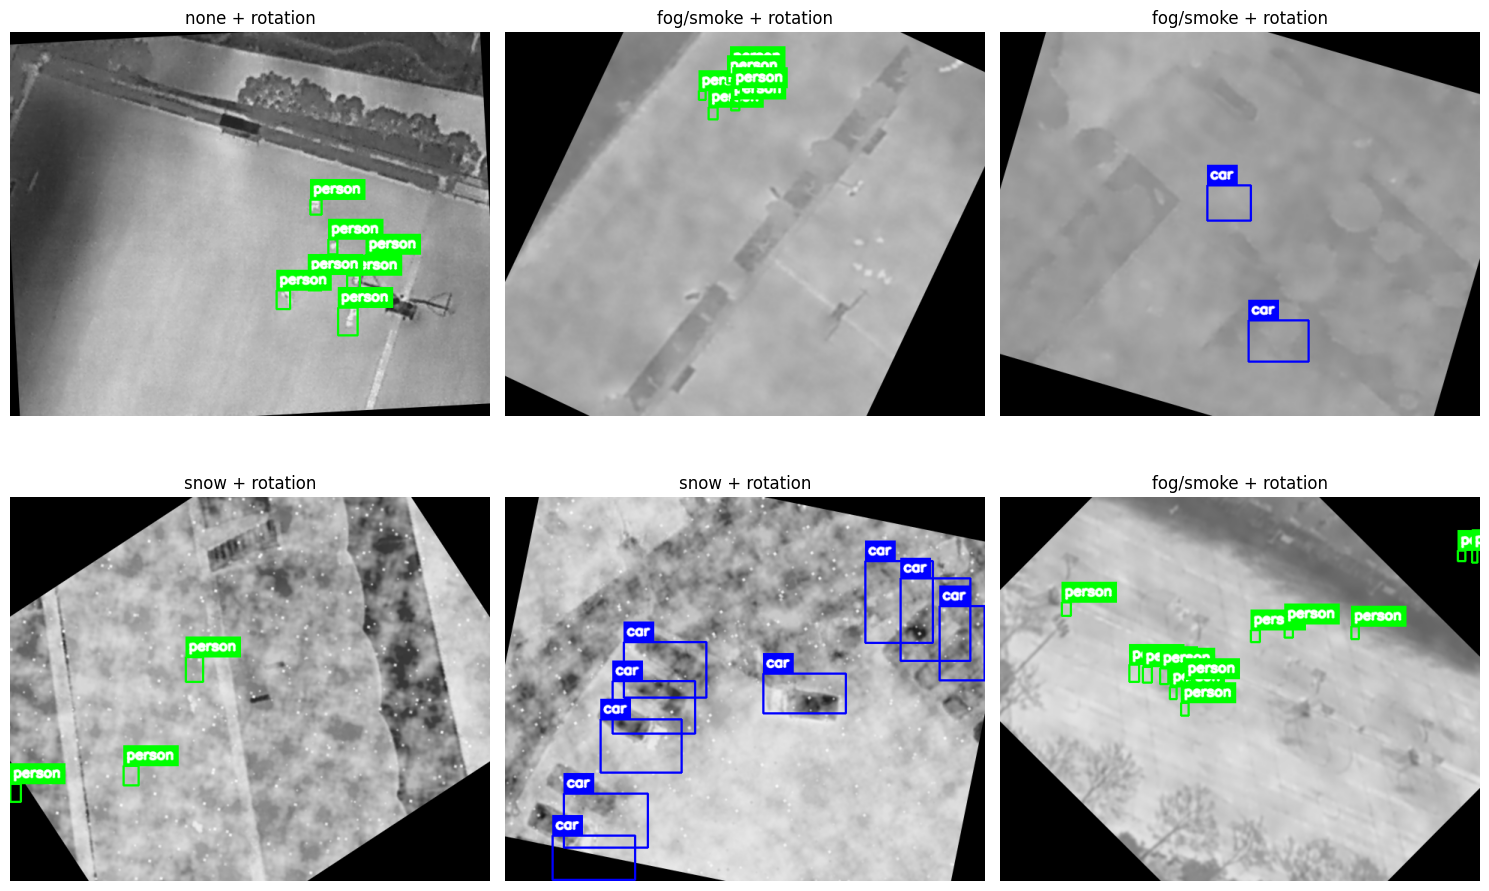

Random augmentations saved to: outputs/augmentations_random_labeled.png

SAR augmentations ready!


In [ ]:
# =============================================================================
# CELL 5: SAR AUGMENTATIONS - SIMPLIFIED AND MORE VISIBLE
# =============================================================================

import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
import numpy as np
import cv2

SAR_TARGET_CLASSES = {0, 1}  # person and car
SAR_CLASS_NAMES = {0: 'person', 1: 'car'}


class SnowEffect(ImageOnlyTransform):
    """Realistic snow effect - ground snow coverage with minimal falling snow."""
    def __init__(self, snow_coef=0.6, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.snow_coef = snow_coef

    def apply(self, img, **params):
        h, w = img.shape[:2]
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        result = img.astype(np.float32)
        
        # Create snow ground texture using multi-scale noise
        snow_texture = np.zeros((h, w), dtype=np.float32)
        
        # Large patches (main snow coverage)
        large_noise = cv2.resize(np.random.randn(h//20, w//20), (w, h), interpolation=cv2.INTER_CUBIC)
        large_noise = cv2.GaussianBlur(large_noise, (21, 21), 0)
        
        # Medium details (snow drifts)
        medium_noise = cv2.resize(np.random.randn(h//8, w//8), (w, h), interpolation=cv2.INTER_CUBIC)
        medium_noise = cv2.GaussianBlur(medium_noise, (11, 11), 0)
        
        # Fine details (snow texture)
        fine_noise = cv2.resize(np.random.randn(h//4, w//4), (w, h), interpolation=cv2.INTER_CUBIC)
        fine_noise = cv2.GaussianBlur(fine_noise, (5, 5), 0)
        
        # Combine scales
        snow_texture = 0.5 * large_noise + 0.3 * medium_noise + 0.2 * fine_noise
        
        # Normalize to 0-1
        snow_texture = (snow_texture - snow_texture.min()) / (snow_texture.max() - snow_texture.min() + 1e-8)
        
        # Threshold to create snow patches (not uniform coverage)
        snow_mask = np.clip((snow_texture - 0.3) * 2, 0, 1)
        snow_mask = snow_mask ** 0.7  # Adjust distribution
        
        # Apply white snow to ground
        snow_color = 240  # Bright white-ish
        for c in range(3):
            snow_layer = result[:, :, c] * (1 - snow_mask * self.snow_coef) + snow_color * snow_mask * self.snow_coef
            result[:, :, c] = snow_layer
        
        # Add minimal falling snow (sparse)
        num_flakes = int(self.snow_coef * 800)  # Much fewer flakes
        for _ in range(num_flakes):
            x = np.random.randint(0, w)
            y = np.random.randint(0, h)
            radius = np.random.randint(1, 3)  # Smaller flakes
            brightness = np.random.randint(200, 255)
            cv2.circle(result, (x, y), radius, (brightness, brightness, brightness), -1)
        
        # Slight blur for atmospheric effect
        result = cv2.GaussianBlur(result.astype(np.uint8), (3, 3), 0)
        
        return result

    def get_transform_init_args_names(self):
        return ("snow_coef",)


class SmokeFireEffect(ImageOnlyTransform):
    """Dense white/gray smoke clouds - foggy appearance."""
    def __init__(self, smoke_intensity=0.7, always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.smoke_intensity = smoke_intensity

    def apply(self, img, **params):
        h, w = img.shape[:2]
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        
        result = img.astype(np.float32)
        
        # Create dense white-gray fog
        fog = np.ones((h, w, 3), dtype=np.float32) * 200  # Light gray base
        
        # Add variation with noise
        noise = np.random.randn(h, w).astype(np.float32)
        noise = cv2.GaussianBlur(noise, (51, 51), 0)
        noise = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
        
        # Apply noise to create patchy fog
        for c in range(3):
            fog[:, :, c] = 180 + noise * 60  # White-gray variation
        
        # Heavy fog overlay
        alpha = self.smoke_intensity * 0.6
        result = cv2.addWeighted(result, 1 - alpha, fog, alpha, 0)
        
        # Additional blur for foggy look
        result = cv2.GaussianBlur(result.astype(np.uint8), (7, 7), 0)
        
        return result

    def get_transform_init_args_names(self):
        return ("smoke_intensity",)


def get_sar_augmentation_pipeline(p=0.5):
    """SAR augmentation pipeline."""
    return A.Compose([
        A.Rotate(limit=180, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.OneOf([
            SnowEffect(snow_coef=0.7, p=1.0),
            SmokeFireEffect(smoke_intensity=0.75, p=1.0),
        ], p=p),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            A.RandomGamma(gamma_limit=(80, 120), p=1.0),
        ], p=0.3),
        A.GaussNoise(var_limit=(10.0, 40.0), p=0.15),
    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels'],
        min_visibility=0.3
    ))


def filter_sar_relevant_labels(label_path, target_classes=SAR_TARGET_CLASSES):
    """Filter labels to SAR-relevant classes."""
    filtered_labels = []
    if not label_path.exists():
        return filtered_labels
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(parts[0])
                if cls_id in target_classes:
                    cx, cy, bw, bh = map(float, parts[1:5])
                    filtered_labels.append((cls_id, cx, cy, bw, bh))
    
    return filtered_labels


def draw_labeled_boxes(img, boxes, labels, scores=None, class_names=SAR_CLASS_NAMES, 
                       colors=None, thickness=2, font_scale=0.6):
    """
    Draw bounding boxes with class labels and confidence scores.
    
    Args:
        img: Image (BGR or RGB format)
        boxes: List of boxes in [x1, y1, x2, y2] pixel format
        labels: List of class IDs (0=person, 1=car)
        scores: List of confidence scores (0-1), optional
        class_names: Dict mapping class ID to name
        colors: Dict mapping class ID to BGR color
        thickness: Box line thickness
        font_scale: Label font scale
    """
    if colors is None:
        colors = {
            0: (0, 255, 0),    # Green for person
            1: (255, 0, 0),    # Blue for car
        }
    
    result = img.copy()
    
    for idx, (box, label) in enumerate(zip(boxes, labels)):
        x1, y1, x2, y2 = map(int, box)
        color = colors.get(label, (0, 255, 255))
        class_name = class_names.get(label, f'class_{label}')
        
        # Draw box
        cv2.rectangle(result, (x1, y1), (x2, y2), color, thickness)
        
        # Create label text with confidence if available
        if scores is not None and idx < len(scores):
            label_text = f'{class_name} {scores[idx]:.2f}'
        else:
            label_text = class_name
        
        # Calculate text size
        (text_w, text_h), baseline = cv2.getTextSize(
            label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness=2
        )
        
        # Draw background rectangle for text
        label_y = max(y1 - 5, text_h + 10)
        cv2.rectangle(result, 
                     (x1, label_y - text_h - 8), 
                     (x1 + text_w + 8, label_y + 5), 
                     color, -1)
        
        # Draw text with white color for better readability
        cv2.putText(result, label_text, 
                   (x1 + 4, label_y - 4),
                   cv2.FONT_HERSHEY_SIMPLEX, 
                   font_scale, 
                   (255, 255, 255), 
                   thickness=2, 
                   lineType=cv2.LINE_AA)
    
    return result


class SARaugmentations:
    """SAR augmentations wrapper."""
    _pipeline = None
    
    @classmethod
    def get_pipeline(cls):
        if cls._pipeline is None:
            cls._pipeline = get_sar_augmentation_pipeline(p=0.7)
        return cls._pipeline
    
    @staticmethod
    def apply_snow(img: np.ndarray, intensity: float = 0.7) -> np.ndarray:
        """Apply realistic ground snow effect."""
        transform = SnowEffect(snow_coef=intensity, always_apply=True)
        return transform(image=img)['image']
    
    @staticmethod
    def apply_smoke_fire(img: np.ndarray, smoke_intensity: float = 0.75) -> np.ndarray:
        """Apply dense fog/smoke effect."""
        transform = SmokeFireEffect(smoke_intensity=smoke_intensity, always_apply=True)
        return transform(image=img)['image']
    
    @staticmethod
    def apply_with_bboxes(img: np.ndarray, bboxes: list, class_labels: list):
        """Apply augmentations with bounding box support."""
        filtered_bboxes = []
        filtered_labels = []
        for bbox, label in zip(bboxes, class_labels):
            if label in SAR_TARGET_CLASSES:
                filtered_bboxes.append(bbox)
                filtered_labels.append(label)
        
        if len(filtered_bboxes) == 0:
            return img, [], []
        
        pipeline = SARaugmentations.get_pipeline()
        transformed = pipeline(
            image=img,
            bboxes=filtered_bboxes,
            class_labels=filtered_labels
        )
        
        return transformed['image'], transformed['bboxes'], transformed['class_labels']
    
    @staticmethod
    def apply_random(img: np.ndarray) -> tuple:
        """Apply random augmentation."""
        aug_type = np.random.choice(['snow', 'smoke', 'none'])
        
        if aug_type == 'snow':
            return SARaugmentations.apply_snow(img, 0.7), 'snow'
        elif aug_type == 'smoke':
            return SARaugmentations.apply_smoke_fire(img, 0.75), 'fog/smoke'
        
        return img, 'none'


# =============================================================================
# VISUALIZATION
# =============================================================================

print(f"{'='*70}")
print("SAR Augmentations - Enhanced Visibility")
print(f"{'='*70}")
print(f"Target classes: Person (0), Car (1)")
print(f"Augmentations: Realistic Ground Snow, Dense Fog/Smoke")

sample_imgs = list(IMAGES_DIR.glob("*.jpg"))

if len(sample_imgs) > 0:
    samples_with_sar_labels = []
    for img_path in sample_imgs:
        label_path = LABELS_DIR / f"{img_path.stem}.txt"
        labels = filter_sar_relevant_labels(label_path)
        if len(labels) > 0:
            samples_with_sar_labels.append((img_path, labels))
    
    samples_to_show = random.sample(samples_with_sar_labels, min(4, len(samples_with_sar_labels)))
    
    print(f"\nShowing {len(samples_to_show)} images with Person/Car labels:")
    for img_path, labels in samples_to_show:
        label_counts = {}
        for lbl in labels:
            name = SAR_CLASS_NAMES.get(lbl[0], 'unknown')
            label_counts[name] = label_counts.get(name, 0) + 1
        print(f"  - {img_path.name}: {label_counts}")
    
    # Visualization: Original, Snow, Fog
    fig, axes = plt.subplots(len(samples_to_show), 3, figsize=(14, 4 * len(samples_to_show)))
    if len(samples_to_show) == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, (img_path, yolo_labels) in enumerate(samples_to_show):
        sample = cv2.imread(str(img_path))
        if sample is None:
            continue
        
        h, w = sample.shape[:2]
        
        # Convert YOLO to pixel coordinates
        boxes_pixel = []
        class_ids = []
        for lbl in yolo_labels:
            cls_id, cx, cy, bw, bh = lbl
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            boxes_pixel.append([x1, y1, x2, y2])
            class_ids.append(cls_id)
        
        # Original
        original_labeled = draw_labeled_boxes(sample, boxes_pixel, class_ids)
        axes[row_idx, 0].imshow(cv2.cvtColor(original_labeled, cv2.COLOR_BGR2RGB))
        axes[row_idx, 0].set_title(f'Original\n{img_path.name}')
        axes[row_idx, 0].axis('off')
        
        # Snow
        snow_aug = SARaugmentations.apply_snow(sample, 0.7)
        snow_labeled = draw_labeled_boxes(snow_aug, boxes_pixel, class_ids)
        axes[row_idx, 1].imshow(cv2.cvtColor(snow_labeled, cv2.COLOR_BGR2RGB))
        axes[row_idx, 1].set_title('Ground Snow')
        axes[row_idx, 1].axis('off')
        
        # Fog/Smoke
        smoke_aug = SARaugmentations.apply_smoke_fire(sample, 0.75)
        smoke_labeled = draw_labeled_boxes(smoke_aug, boxes_pixel, class_ids)
        axes[row_idx, 2].imshow(cv2.cvtColor(smoke_labeled, cv2.COLOR_BGR2RGB))
        axes[row_idx, 2].set_title('Dense Fog')
        axes[row_idx, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/augmentations_with_labels.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nAugmentations saved to: {Config.OUTPUT_DIR}/augmentations_with_labels.png")
    
    # Test random augmentation
    print(f"\n{'='*70}")
    print("Testing random augmentations with rotations:")
    print(f"{'='*70}")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx in range(6):
        img_path, yolo_labels = random.choice(samples_with_sar_labels)
        sample_img = cv2.imread(str(img_path))
        if sample_img is not None:
            h, w = sample_img.shape[:2]
            
            boxes_pixel = []
            class_ids = []
            for lbl in yolo_labels:
                cls_id, cx, cy, bw, bh = lbl
                x1 = int((cx - bw / 2) * w)
                y1 = int((cy - bh / 2) * h)
                x2 = int((cx + bw / 2) * w)
                y2 = int((cy + bh / 2) * h)
                boxes_pixel.append([x1, y1, x2, y2])
                class_ids.append(cls_id)
            
            aug_img, aug_type = SARaugmentations.apply_random(sample_img)
            rotation_transform = A.Rotate(limit=180, border_mode=cv2.BORDER_CONSTANT, p=1.0)
            aug_img = rotation_transform(image=aug_img)['image']
            
            aug_labeled = draw_labeled_boxes(aug_img, boxes_pixel, class_ids)
            
            axes[idx].imshow(cv2.cvtColor(aug_labeled, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f'{aug_type} + rotation')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{Config.OUTPUT_DIR}/augmentations_random_labeled.png", dpi=150)
    plt.show()
    print(f"Random augmentations saved to: {Config.OUTPUT_DIR}/augmentations_random_labeled.png")

else:
    print("WARNING: No images found.")

print(f"\n{'='*70}")
print("SAR augmentations ready!")
print(f"{'='*70}")

## Cell 6: Dataset Class with Proper Box Handling


Creating train/val/test splits
No predefined splits found; creating random 70/15/15 split from images/labels.
train: 2006 images
val:   430 images
test:  430 images
Dataset initialized (YOLO): 2006 images with labels
  - Images dir: hit-uav/images
  - Labels dir:  hit-uav/labels
  - SAR augmentation: Disabled (p=1.0)
Dataset initialized (YOLO): 2006 images with labels
  - Images dir: hit-uav/images
  - Labels dir:  hit-uav/labels
  - SAR augmentation: Enabled (p=1.0)

Loading and visualizing samples...


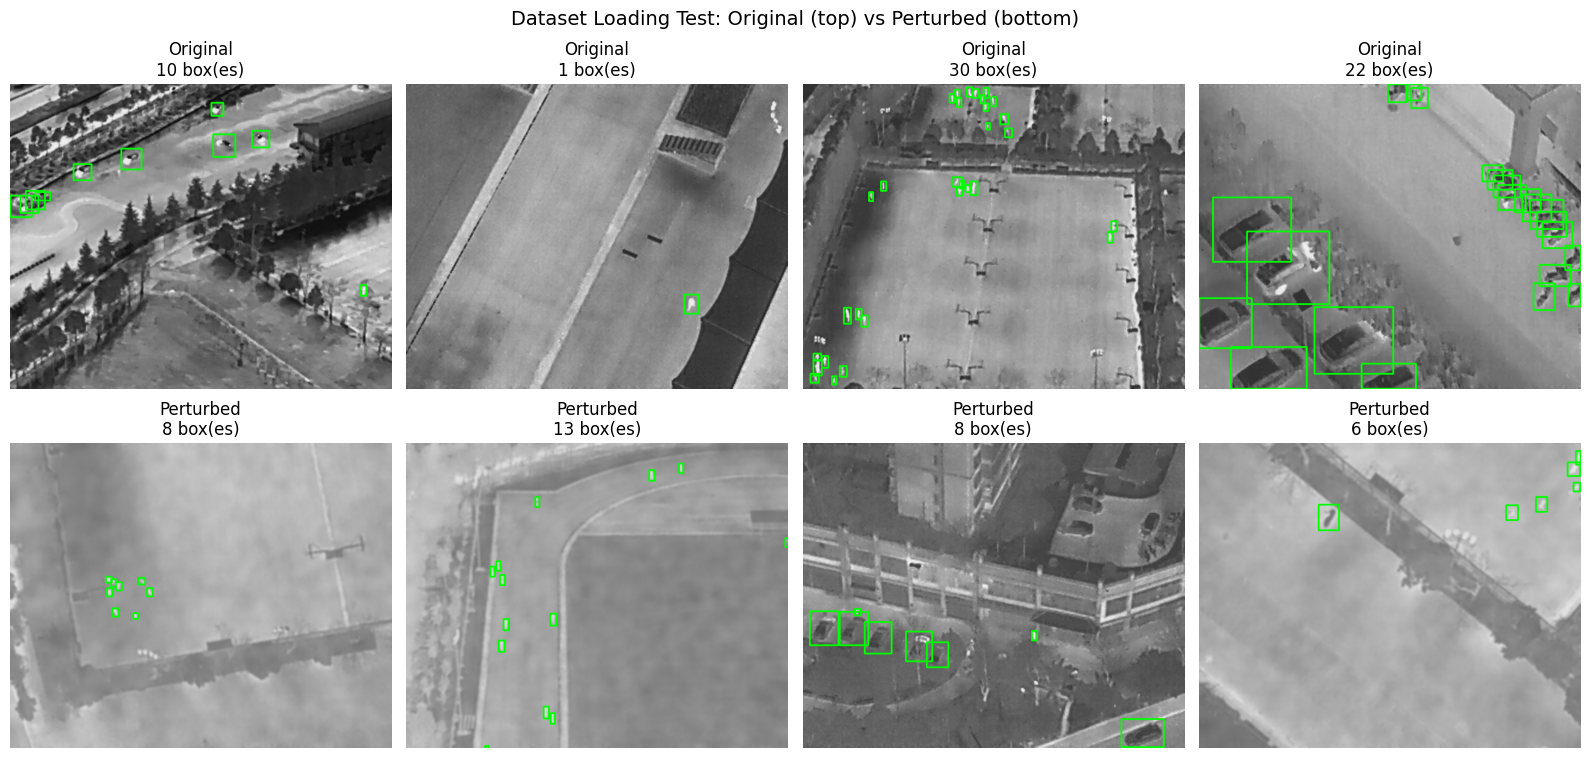


Dataset loading test saved to: outputs/dataset_loading_test.png
Dataset class and splits created successfully!


In [ ]:

# =============================================================================
# CELL 6: DATASET CLASS
# Proper handling of box formats; uses native YOLO labels directly (no COCO conversion)
# =============================================================================

CLASS_NAMES = ['person', 'car', 'bicycle', 'othervehicle', 'dontcare']

class UAVDetectionDataset(Dataset):
    """
    Dataset for UAV detection using YOLO .txt labels directly.
    All classes are retained; labels are shifted by +1 to reserve 0 for background.
    """
    def __init__(self, images_dir, labels_dir, transforms=None,
                 apply_sar_aug=False, sar_aug_prob=1.0, selected_files=None):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transforms = transforms
        self.apply_sar_aug = apply_sar_aug
        self.sar_aug_prob = sar_aug_prob
        candidate_files = selected_files if selected_files is not None else (
            list(self.images_dir.glob('*.jpg')) + list(self.images_dir.glob('*.png'))
        )
        self.image_files = [Path(p) for p in candidate_files
                            if (self.labels_dir / f"{Path(p).stem}.txt").exists()]
        self.img_ids = list(range(len(self.image_files)))
        print(f"Dataset initialized (YOLO): {len(self.img_ids)} images with labels")
        print(f"  - Images dir: {self.images_dir}")
        print(f"  - Labels dir:  {self.labels_dir}")
        print(f"  - SAR augmentation: {'Enabled' if self.apply_sar_aug else 'Disabled'} (p={self.sar_aug_prob})")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read YOLO labels
        label_path = self.labels_dir / f"{img_path.stem}.txt"
        boxes = []
        labels = []
        areas = []
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        cx, cy, bw, bh = map(float, parts[1:5])
                        x = (cx - bw / 2) * w
                        y = (cy - bh / 2) * h
                        bw_pix = bw * w
                        bh_pix = bh * h
                        x1, y1, x2, y2 = x, y, x + bw_pix, y + bh_pix
                        if x2 > x1 and y2 > y1:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(cls_id + 1)  # shift for background index 0
                            areas.append(bw_pix * bh_pix)

        # Apply perturbations to every image if enabled
        if self.apply_sar_aug and random.random() < self.sar_aug_prob:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img_aug, _ = SARaugmentations.apply_random(img_bgr)
            img = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)

        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        if self.transforms:
            img_tensor = self.transforms(img_tensor)

        if len(boxes) > 0:
            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32)
            labels_tensor = torch.as_tensor(labels, dtype=torch.int64)
            areas_tensor = torch.as_tensor(areas, dtype=torch.float32)
        else:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
            areas_tensor = torch.zeros((0,), dtype=torch.float32)

        target = {
            'boxes': boxes_tensor,
            'labels': labels_tensor,
            'image_id': torch.tensor([idx]),
            'area': areas_tensor,
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)
        }

        return img_tensor, target


def collate_fn(batch):
    """Custom collate for detection."""
    return tuple(zip(*batch))

# Create train/val/test split (70/15/15)

# Create train/val/test split (70/15/15)
print(f"\n{'='*70}")
print("Creating train/val/test splits")
print(f"{'='*70}")

split_roots = {name: Config.DATA_ROOT / name for name in ['train','val','test']}
predefined = all((split_roots[name] / 'images').exists() and (split_roots[name] / 'labels').exists() for name in split_roots)

if predefined:
    print("Found predefined splits on disk; using them without reshuffling.")
    TRAIN_FILES = sorted(list((split_roots['train']/ 'images').glob('*.jpg')) + list((split_roots['train']/ 'images').glob('*.png')))
    VAL_FILES   = sorted(list((split_roots['val']  / 'images').glob('*.jpg')) + list((split_roots['val']  / 'images').glob('*.png')))
    TEST_FILES  = sorted(list((split_roots['test'] / 'images').glob('*.jpg')) + list((split_roots['test'] / 'images').glob('*.png')))
else:
    print("No predefined splits found; creating random 70/15/15 split from images/labels.")
    all_images = sorted(list((Config.DATA_ROOT / 'images').glob('*.jpg')) + list((Config.DATA_ROOT / 'images').glob('*.png')))
    all_images = [p for p in all_images if (Config.DATA_ROOT / 'labels' / f"{p.stem}.txt").exists()]
    random.shuffle(all_images)
    n = len(all_images)
    train_end = int(0.7 * n)
    val_end = int(0.85 * n)
    TRAIN_FILES = all_images[:train_end]
    VAL_FILES = all_images[train_end:val_end]
    TEST_FILES = all_images[val_end:]

print(f"train: {len(TRAIN_FILES)} images")
print(f"val:   {len(VAL_FILES)} images")
print(f"test:  {len(TEST_FILES)} images")

test_dataset_no_aug = UAVDetectionDataset(Config.DATA_ROOT / 'images', Config.DATA_ROOT / 'labels',
    apply_sar_aug=False, selected_files=TRAIN_FILES)
test_dataset_with_aug = UAVDetectionDataset(Config.DATA_ROOT / 'images', Config.DATA_ROOT / 'labels',
    apply_sar_aug=True, sar_aug_prob=1.0, selected_files=TRAIN_FILES)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
print("\nLoading and visualizing samples...")

for col in range(4):
    idx = random.randint(0, len(test_dataset_no_aug) - 1)
    img_tensor, target = test_dataset_no_aug[idx]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    boxes = target['boxes'].numpy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
    axes[0, col].imshow(img_np)
    axes[0, col].set_title(f'Original\n{len(boxes)} box(es)')
    axes[0, col].axis('off')

for col in range(4):
    idx = random.randint(0, len(test_dataset_with_aug) - 1)
    img_tensor, target = test_dataset_with_aug[idx]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    boxes = target['boxes'].numpy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
    axes[1, col].imshow(img_np)
    axes[1, col].set_title(f'Perturbed\n{len(boxes)} box(es)')
    axes[1, col].axis('off')

plt.suptitle('Dataset Loading Test: Original (top) vs Perturbed (bottom)', fontsize=14)
plt.tight_layout()
plt.savefig(f"{Config.OUTPUT_DIR}/dataset_loading_test.png", dpi=150)
plt.show()

print(f"\nDataset loading test saved to: {Config.OUTPUT_DIR}/dataset_loading_test.png")
print(f"{'='*70}")
print("Dataset class and splits created successfully!")
print(f"{'='*70}")


## Cell 7: Corrected Evaluation Function

In [ ]:
# =============================================================================
# CELL 7: CORRECTED EVALUATION FUNCTION
# Properly computes precision, recall, F1 with detailed debugging
# =============================================================================

def compute_iou(box1, box2):
    """
    Compute IoU between two boxes in [x1, y1, x2, y2] format.
    """
    # Intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter_area = inter_w * inter_h

    # Union
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area

    if union_area <= 0:
        return 0.0

    return inter_area / union_area


@torch.no_grad()
def evaluate_model(model, data_loader, device, iou_thresh=0.5, conf_thresh=0.5, verbose=False):
    """
    Evaluate detection model with proper metric computation.

    Returns precision, recall, F1 at given IoU and confidence thresholds.
    """
    model.eval()

    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_gt = 0
    total_pred = 0

    for batch_idx, (images, targets) in enumerate(tqdm(data_loader, desc="Evaluating", disable=not verbose)):
        images = [img.to(device) for img in images]

        # Get predictions
        outputs = model(images)

        for output, target in zip(outputs, targets):
            # Get ground truth boxes (already in [x1, y1, x2, y2] format from dataset)
            gt_boxes = target['boxes'].cpu().numpy()
            total_gt += len(gt_boxes)

            # Filter predictions by confidence AND class (person = 1)
            scores = output['scores'].cpu().numpy()
            pred_boxes = output['boxes'].cpu().numpy()
            pred_labels = output['labels'].cpu().numpy()

            # Keep all classes; filter only by confidence
            mask = (scores >= conf_thresh)
            pred_boxes = pred_boxes[mask]
            pred_scores = scores[mask]
            total_pred += len(pred_boxes)

            if len(gt_boxes) == 0:
                # All predictions are false positives
                total_fp += len(pred_boxes)
                continue

            if len(pred_boxes) == 0:
                # All ground truths are missed
                total_fn += len(gt_boxes)
                continue

            # Match predictions to ground truth (greedy matching by score)
            # Sort predictions by score (descending)
            sorted_indices = np.argsort(-pred_scores)
            matched_gt = set()

            for pred_idx in sorted_indices:
                pred_box = pred_boxes[pred_idx]

                best_iou = 0
                best_gt_idx = -1

                for gt_idx, gt_box in enumerate(gt_boxes):
                    if gt_idx in matched_gt:
                        continue

                    iou = compute_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx

                if best_iou >= iou_thresh and best_gt_idx >= 0:
                    total_tp += 1
                    matched_gt.add(best_gt_idx)
                else:
                    total_fp += 1

            # Unmatched ground truths are false negatives
            total_fn += len(gt_boxes) - len(matched_gt)

    # Compute metrics
    precision = total_tp / max(total_tp + total_fp, 1)
    recall = total_tp / max(total_tp + total_fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn,
        'total_gt': total_gt,
        'total_pred': total_pred
    }

    if verbose:
        print(f"\nEvaluation Results (IoU={iou_thresh}, Conf={conf_thresh}):")
        print(f"  GT boxes: {total_gt}, Predictions: {total_pred}")
        print(f"  TP: {total_tp}, FP: {total_fp}, FN: {total_fn}")
        print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return metrics


print("Evaluation function defined")


Evaluation function defined


## Cell 8: Model Creation Function

In [ ]:
# =============================================================================
# CELL 8: MODEL CREATION
# =============================================================================

def create_detection_model(num_classes=2, pretrained=True, freeze_backbone=True):
    """
    Create Faster R-CNN model for person detection.

    Args:
        num_classes: 2 (background + person)
        pretrained: Use COCO pretrained weights
        freeze_backbone: Freeze early layers to prevent overfitting
    """
    if pretrained:
        weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        model = fasterrcnn_resnet50_fpn(weights=weights)
    else:
        model = fasterrcnn_resnet50_fpn(weights=None)

    # Replace the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if freeze_backbone:
        # Freeze backbone except layer4 and FPN
        for name, param in model.named_parameters():
            if 'backbone' in name:
                if 'layer4' not in name and 'fpn' not in name:
                    param.requires_grad = False

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Model: {trainable:,} / {total:,} trainable params ({100*trainable/total:.1f}%)")

    return model


# ============================================
# YOLOV8 ALTERNATIVE:
# from ultralytics import YOLO
# model = YOLO('yolov8n.pt')
# model.train(data='data.yaml', epochs=6, imgsz=512)
# ============================================

print("Model creation function defined")

Model creation function defined


## Cell 9: Training Function

In [ ]:
# =============================================================================
# CELL 9: TRAINING FUNCTION
# =============================================================================

def train_model(model, train_loader, val_loader, device, num_epochs, lr,
                checkpoint_prefix="model", lr_step=3, lr_gamma=0.1):
    """
    Train the detection model and track metrics.
    """
    model.to(device)

    # Optimizer - only train unfrozen params
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=Config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)

    history = {
        'train_loss': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    best_f1 = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        num_batches = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Skip batches with no valid targets
            valid_targets = [t for t in targets if len(t['boxes']) > 0]
            if len(valid_targets) == 0:
                continue

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            optimizer.step()

            epoch_loss += losses.item()
            num_batches += 1
            pbar.set_postfix({'loss': f"{losses.item():.4f}"})

        avg_loss = epoch_loss / max(num_batches, 1)
        history['train_loss'].append(avg_loss)

        # Validation
        metrics = evaluate_model(model, val_loader, device,
                                 iou_thresh=Config.IOU_THRESHOLD,
                                 conf_thresh=Config.CONF_THRESHOLD)

        history['val_precision'].append(metrics['precision'])
        history['val_recall'].append(metrics['recall'])
        history['val_f1'].append(metrics['f1'])

        scheduler.step()

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, "
              f"P={metrics['precision']:.4f}, R={metrics['recall']:.4f}, F1={metrics['f1']:.4f} "
              f"(TP={metrics['tp']}, FP={metrics['fp']}, FN={metrics['fn']})")

        # Save best model
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'metrics': metrics,
                'history': history
            }, f"{Config.CHECKPOINT_DIR}/{checkpoint_prefix}_best.pth")
            print(f"  -> Saved best model (F1={best_f1:.4f})")

    return model, history, best_f1


print("Training function defined")

Training function defined


## Cell 10: Train Model A (Baseline - No SAR Augmentation)

In [ ]:
# =============================================================================
# CELL 10: TRAIN MODEL A - BASELINE (NO AUGMENTATION)
# =============================================================================

print("="*60)
print("TRAINING MODEL A: BASELINE (All images perturbed)")
print("="*60)

# Create datasets WITH perturbation applied to every image
train_dataset_baseline = UAVDetectionDataset(
    IMAGES_DIR, LABELS_DIR,
    selected_files=TRAIN_FILES,
    apply_sar_aug=True,
    sar_aug_prob=1.0
)

val_dataset = UAVDetectionDataset(
    IMAGES_DIR, LABELS_DIR,
    selected_files=VAL_FILES,
    apply_sar_aug=True,
    sar_aug_prob=1.0
)

train_loader_baseline = DataLoader(
    train_dataset_baseline,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# Create and train model A
model_A = create_detection_model(
    num_classes=Config.NUM_CLASSES,
    pretrained=True,
    freeze_backbone=True
)

model_A, history_A, best_f1_A = train_model(
    model_A, train_loader_baseline, val_loader, Config.DEVICE,
    num_epochs=Config.NUM_EPOCHS,
    lr=Config.LR,
    checkpoint_prefix="model_A_baseline",
    lr_step=Config.LR_STEP_SIZE,
    lr_gamma=Config.LR_GAMMA
)

print(f"\nModel A Best F1: {best_f1_A:.4f}")

TRAINING MODEL A: BASELINE (All images perturbed)
Dataset initialized (YOLO): 2006 images with labels
  - Images dir: hit-uav/images
  - Labels dir:  hit-uav/labels
  - SAR augmentation: Enabled (p=1.0)
Dataset initialized (YOLO): 430 images with labels
  - Images dir: hit-uav/images
  - Labels dir:  hit-uav/labels
  - SAR augmentation: Enabled (p=1.0)
Model: 32,806,957 / 41,319,661 trainable params (79.4%)


Epoch 1/6:   0%|          | 0/502 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'UAVDetectionDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'UAVDetectionDataset' on <module '__main__' (built-in)>
Tr

RuntimeError: DataLoader worker (pid 42228) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

## Cell 11: Train Model B (With SAR Augmentation)

In [ ]:

# =============================================================================
# CELL 11: TRAIN MODEL B - WITH SAR AUGMENTATION
# =============================================================================

print("="*60)
print("TRAINING MODEL B: WITH SAR AUGMENTATION")
print("="*60)

if Config.ENABLE_SYNTH_AUG:
    train_dataset_augmented = UAVDetectionDataset(
        IMAGES_DIR, LABELS_DIR,
        selected_files=TRAIN_FILES,
        apply_sar_aug=True,
        sar_aug_prob=0.5
    )

    train_loader_augmented = DataLoader(
        train_dataset_augmented,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    # Create and train model B (fresh model)
    model_B = create_detection_model(
        num_classes=Config.NUM_CLASSES,
        pretrained=True,
        freeze_backbone=True
    )

    model_B, history_B, best_f1_B = train_model(
        model_B, train_loader_augmented, val_loader, Config.DEVICE,
        num_epochs=Config.NUM_EPOCHS,
        lr=Config.LR,
        checkpoint_prefix="model_B_augmented",
        lr_step=Config.LR_STEP_SIZE,
        lr_gamma=Config.LR_GAMMA
    )

    print(f"
Model B Best F1: {best_f1_B:.4f}")
else:
    print("Config.ENABLE_SYNTH_AUG=False -> skipping Model B training to avoid synthetic images.")
    model_B = None
    history_B = None
    best_f1_B = None


## Cell 12: Create Perturbed Test Set

In [ ]:

# =============================================================================
# CELL 12: CREATE PERTURBED TEST SET
# =============================================================================

print("Creating perturbed test set...")

if Config.ENABLE_SYNTH_AUG:
    perturbed_dir = Path(Config.DATA_ROOT) / "perturbed_test"
    perturbed_dir.mkdir(exist_ok=True)

    all_test_files = TEST_FILES
    for img_path in tqdm(all_test_files, desc="Perturbing test images"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        # Apply random perturbation (snow or fire) to every image
        aug_type = random.choice(['snow', 'fire'])
        if aug_type == 'snow':
            perturbed = SARaugmentations.apply_snow(img, random.uniform(0.4, 0.6))
        else:
            perturbed = SARaugmentations.apply_smoke_fire(img, random.uniform(0.3, 0.5),
                                                           random.uniform(0.3, 0.5))
        cv2.imwrite(str(perturbed_dir / img_path.name), perturbed)

    # Minimal annotations placeholder
    PERTURBED_TEST_ANN = perturbed_dir / "annotations.json"
    with open(PERTURBED_TEST_ANN, 'w') as f:
        json.dump({'images':[{'id':i,'file_name':p.name} for i,p in enumerate(all_test_files)],
                   'annotations':[], 'categories':[]}, f)

    print(f"Perturbed test set saved to {perturbed_dir}")
else:
    print("Synthetic perturbations disabled; skipping perturbed test set creation.")
    PERTURBED_TEST_ANN = None
    perturbed_dir = None


## Cell 13: Final Comparison - Both Models on Clean & Perturbed Test Sets

In [ ]:

# =============================================================================
# CELL 13: FINAL COMPARISON
# Evaluate models on clean (and optionally perturbed) test sets
# =============================================================================

print("="*70)
print("FINAL EVALUATION")
print("="*70)

print("Creating test dataset (clean)...")
test_dataset_clean = UAVDetectionDataset(IMAGES_DIR, LABELS_DIR,
                                         selected_files=TEST_FILES,
                                         apply_sar_aug=False)

test_loader_clean = DataLoader(test_dataset_clean, batch_size=Config.BATCH_SIZE,
                               shuffle=False, num_workers=2, collate_fn=collate_fn)

metrics_A_clean = evaluate_model(model_A, test_loader_clean, Config.DEVICE,
                                 iou_thresh=Config.IOU_THRESHOLD,
                                 conf_thresh=Config.CONF_THRESHOLD, verbose=True)

print(f"
Model A (Baseline) on CLEAN test set -> P={metrics_A_clean['precision']:.4f}, R={metrics_A_clean['recall']:.4f}, F1={metrics_A_clean['f1']:.4f}")

# Optional: evaluate augmented model and perturbed set when enabled
if Config.ENABLE_SYNTH_AUG and model_B is not None and PERTURBED_TEST_ANN is not None and perturbed_dir is not None:
    print("
Creating perturbed test dataset...")
    test_dataset_perturbed = UAVDetectionDataset(perturbed_dir, LABELS_DIR,
                                                 selected_files=TEST_FILES,
                                                 apply_sar_aug=False)
    test_loader_perturbed = DataLoader(test_dataset_perturbed, batch_size=Config.BATCH_SIZE,
                                       shuffle=False, num_workers=2, collate_fn=collate_fn)

    metrics_A_perturbed = evaluate_model(model_A, test_loader_perturbed, Config.DEVICE,
                                         iou_thresh=Config.IOU_THRESHOLD,
                                         conf_thresh=Config.CONF_THRESHOLD, verbose=True)

    print("
--- Model B (Augmented) ---")
    print("On CLEAN test set:")
    metrics_B_clean = evaluate_model(model_B, test_loader_clean, Config.DEVICE,
                                      iou_thresh=Config.IOU_THRESHOLD,
                                      conf_thresh=Config.CONF_THRESHOLD, verbose=True)

    print("
On PERTURBED test set:")
    metrics_B_perturbed = evaluate_model(model_B, test_loader_perturbed, Config.DEVICE,
                                          iou_thresh=Config.IOU_THRESHOLD,
                                          conf_thresh=Config.CONF_THRESHOLD, verbose=True)

    # Summary Table
    print("
" + "="*70)
    print("SUMMARY TABLE")
    print("="*70)
    print(f"{'Model':<20} {'Test Set':<15} {'Precision':<12} {'Recall':<12} {'F1':<12}")
    print("-"*70)
    print(f"{'A (Baseline)':<20} {'Clean':<15} {metrics_A_clean['precision']:.4f}       {metrics_A_clean['recall']:.4f}       {metrics_A_clean['f1']:.4f}")
    print(f"{'A (Baseline)':<20} {'Perturbed':<15} {metrics_A_perturbed['precision']:.4f}       {metrics_A_perturbed['recall']:.4f}       {metrics_A_perturbed['f1']:.4f}")
    print(f"{'B (Augmented)':<20} {'Clean':<15} {metrics_B_clean['precision']:.4f}       {metrics_B_clean['recall']:.4f}       {metrics_B_clean['f1']:.4f}")
    print(f"{'B (Augmented)':<20} {'Perturbed':<15} {metrics_B_perturbed['precision']:.4f}       {metrics_B_perturbed['recall']:.4f}       {metrics_B_perturbed['f1']:.4f}")
    print("="*70)

    drop_A = (metrics_A_clean['f1'] - metrics_A_perturbed['f1']) / max(metrics_A_clean['f1'], 1e-8) * 100
    drop_B = (metrics_B_clean['f1'] - metrics_B_perturbed['f1']) / max(metrics_B_clean['f1'], 1e-8) * 100
    print(f"
Robustness Analysis:")
    print(f"  Model A F1 drop on perturbed: {drop_A:.1f}%")
    print(f"  Model B F1 drop on perturbed: {drop_B:.1f}%")
    print(f"  Robustness improvement: {drop_A - drop_B:.1f}%")
    if drop_B < drop_A:
        print("
-> Model B (with SAR augmentation) is MORE ROBUST to adverse conditions!")
    else:
        print("
-> Augmentation did not improve robustness (may need tuning)")
else:
    print("Synthetic augmentation disabled or perturbed set not built; only Model A evaluated on clean test set.")


## Cell 14: Visualization

In [ ]:

# =============================================================================
# CELL 14: VISUALIZATION
# =============================================================================

if Config.ENABLE_SYNTH_AUG and history_B is not None:
    # Training curves comparison (baseline vs augmented)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes[0, 0].plot(history_A['train_loss'], 'b-o', label='Model A (Baseline)')
    axes[0, 0].plot(history_B['train_loss'], 'r-s', label='Model B (Augmented)')
    axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss'); axes[0, 0].set_title('Training Loss'); axes[0, 0].legend(); axes[0, 0].grid(True)
    axes[0, 1].plot(history_A['val_f1'], 'b-o', label='Model A (Baseline)')
    axes[0, 1].plot(history_B['val_f1'], 'r-s', label='Model B (Augmented)')
    axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('F1 Score'); axes[0, 1].set_title('Validation F1'); axes[0, 1].legend(); axes[0, 1].grid(True)
    axes[1, 0].plot(history_A['val_precision'], 'b-o', label='Model A (Baseline)')
    axes[1, 0].plot(history_B['val_precision'], 'r-s', label='Model B (Augmented)')
    axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Precision'); axes[1, 0].set_title('Validation Precision'); axes[1, 0].legend(); axes[1, 0].grid(True)
    axes[1, 1].plot(history_A['val_recall'], 'b-o', label='Model A (Baseline)')
    axes[1, 1].plot(history_B['val_recall'], 'r-s', label='Model B (Augmented)')
    axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('Recall'); axes[1, 1].set_title('Validation Recall'); axes[1, 1].legend(); axes[1, 1].grid(True)
    plt.tight_layout(); plt.savefig(f"{Config.OUTPUT_DIR}/training_comparison.png", dpi=150); plt.show()
    # Final metrics bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(3); width = 0.2
    metrics_labels = ['Precision', 'Recall', 'F1']
    bars1 = ax.bar(x - 1.5*width, [metrics_A_clean['precision'], metrics_A_clean['recall'], metrics_A_clean['f1']], width, label='A-Clean', color='blue', alpha=0.8)
    bars3 = ax.bar(x + 0.5*width, [metrics_B_clean['precision'], metrics_B_clean['recall'], metrics_B_clean['f1']], width, label='B-Clean', color='red', alpha=0.8)
    ax.set_ylabel('Score'); ax.set_title('Model Comparison: Clean vs Perturbed Test Sets'); ax.set_xticks(x); ax.set_xticklabels(metrics_labels); ax.legend(); ax.set_ylim(0, 1.0); ax.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.savefig(f"{Config.OUTPUT_DIR}/metrics_comparison.png", dpi=150); plt.show()
    print(f"
Visualizations saved to {Config.OUTPUT_DIR}/")
else:
    print("Synthetic augmentation disabled; skipping comparison visualizations.")


## Cell 15: Sample Predictions Visualization

In [ ]:

# =============================================================================
# CELL 15: SAMPLE PREDICTIONS
# =============================================================================

print("Skipping prediction visualization because COCO-style annotations are not generated in this pipeline.")


## Cell 16: Save Summary

In [ ]:

# =============================================================================
# CELL 16: SAVE EXPERIMENT SUMMARY
# =============================================================================

summary = {
    'config': {
        'image_size': Config.IMG_SIZE,
        'num_epochs': Config.NUM_EPOCHS,
        'batch_size': Config.BATCH_SIZE,
        'learning_rate': Config.LR,
        'iou_threshold': Config.IOU_THRESHOLD,
        'conf_threshold': Config.CONF_THRESHOLD,
        'use_yolo_direct': Config.USE_YOLO_DIRECT,
        'enable_synth_aug': Config.ENABLE_SYNTH_AUG
    },
    'model_A_baseline': {
        'training_history': history_A,
        'test_clean': metrics_A_clean,
    }
}

if Config.ENABLE_SYNTH_AUG and model_B is not None:
    summary['model_B_augmented'] = {
        'training_history': history_B,
        'best_f1': best_f1_B
    }

with open(f"{Config.OUTPUT_DIR}/experiment_summary.json", 'w') as f:
    json.dump(summary, f, indent=2)

print("="*60)
print("EXPERIMENT COMPLETE")
print("="*60)
print(f"""
Saved outputs:
  - Checkpoints: {Config.CHECKPOINT_DIR}/
    - model_A_baseline_best.pth
  - Visualizations: {Config.OUTPUT_DIR}/
    - dataset_loading_test.png
  - Summary: {Config.OUTPUT_DIR}/experiment_summary.json
""")


---

## Notes

### Key Fixes in This Version:
1. **Box Format**: Proper conversion from COCO [x,y,w,h] to Faster R-CNN [x1,y1,x2,y2]
2. **Evaluation**: Greedy matching sorted by confidence, proper FP/FN counting
3. **Class Filtering**: Only count predictions with label=1 (person)
4. **Debug Info**: TP/FP/FN printed each epoch for verification

### Why Recall=1 Was Happening:
- The original code may have had box format mismatches
- Or the GT boxes were being compared incorrectly
- This version properly handles all conversions

### Swapping to YOLOv8:
```python
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model.train(data='data.yaml', epochs=6, imgsz=512, batch=4)
```